In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras
keras.__version__
import os, shutil


Using TensorFlow backend.


이 데이터셋은 25,000개의 강아지와 고양이 이미지(클래스마다 12,500개)를 담고 있고 (압축해서) 543MB 크기입니다. 다운로드하고 압축을 해제한 후 세 개의 서브셋이 들어 있는 새로운 데이터셋을 만들 것입니다. 클래스마다 1,000개의 샘플로 이루어진 훈련 세트, 클래스마다 500개의 샘플로 이루어진 검증 세트, 클래스마다 500개의 샘플로 이루어진 테스트 세트입니다.

다음은 이를 처리하는 코드입니다:

In [2]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './cats_and_dogs_small'

In [3]:
os.getcwd()

'C:\\Users\\kynk9\\Desktop\\ch'

In [4]:
# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')

In [6]:
# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')

In [7]:
# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')

In [8]:
# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [9]:
# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')

In [10]:
# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [23]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


In [14]:

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

컴파일 단계에서 이전과 같이 RMSprop 옵티마이저를 선택하겠습니다.
네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용합니다


In [16]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 데이터 전처리
- 데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 

- 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1. 사진 파일을 읽습니다.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3. 그다음 부동 소수 타입의 텐서로 변환합니다.
4. 픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).
5. 좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 

6. 케라스는 keras.preprocessing.image에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 ImageDataGenerator 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.



In [24]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        './cats_and_dogs_small/train',
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
        './cats_and_dogs_small/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


이 제너레이터의 출력 하나를 살펴보죠. 

이 출력은 150 × 150 RGB 이미지의 배치((20, 150, 150, 3) 크기)와 이진 레이블의 배치((20,) 크기)입니다. 

각 배치에는 20개의 샘플(배치 크기)이 있습니다. 

제너레이터는 이 배치를 무한정 만들어 냅니다.

타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프안의 어디에선가 break 문을 사용해야 합니다.



In [25]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다.

fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다.

이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대합니다.

데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 합니다.

steps_per_epoch 매개변수에서 이를 설정합니다.

제너레이터로부터 steps_per_epoch 개의 배치만큼 뽑은 다음, 즉 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어갑니다.

여기서는 20개의 샘플이 하나의 배치이므로 2000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것입니다.

fit_generator를 사용할 때 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다.

이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. 

validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다.

따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 합니다.


 실제로 한 epoch마다 사용되는 학습데이터의 수는 steps_per_epoch * batch_size가 됩니다.




In [26]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 13s 127ms/step - loss: 0.6928 - acc: 0.5215 - val_loss: 0.6711 - val_acc: 0.6240
Epoch 2/30
100/100 [==============================] - 8s 77ms/step - loss: 0.6558 - acc: 0.6050 - val_loss: 0.6303 - val_acc: 0.6230
Epoch 3/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6019 - acc: 0.6590 - val_loss: 0.6183 - val_acc: 0.6430
Epoch 4/30
100/100 [==============================] - 7s 73ms/step - loss: 0.5600 - acc: 0.7130 - val_loss: 0.5961 - val_acc: 0.6750
Epoch 5/30
100/100 [==============================] - 7s 73ms/step - loss: 0.5357 - acc: 0.7355 - val_loss: 0.6234 - val_acc: 0.6560
Epoch 6/30
100/100 [==============================] - 7s 73ms/step - loss: 0.5094 - acc: 0.7470 - val_loss: 0.5703 - val_acc: 0.6950
Epoch 7/30
100/100 [==============================] - 7s 72ms/step - loss: 0.4800 - acc: 0.7665 - val_loss: 0.6361 - val_acc: 0.6570
Epoch 8/30
100/100 [==============================] - 7s 72ms/step 

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

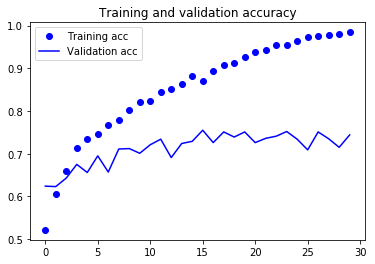

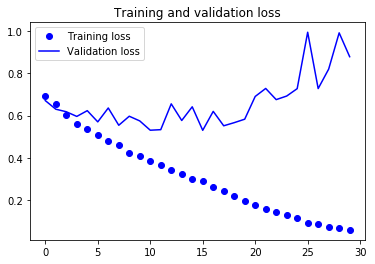

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
model.save('cats_and_dogs_small_2.h5')